# Metabolic modeling using phenotype microarray (PM) data
- Simulations using data from Lei, et al (2013)
    - https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0056545#s4

In [1]:
# Load libraries
import pandas as pd
import cobra
import copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

In [328]:
# Load models
cd630=cobra.io.read_sbml_model("models/iCdG709.sbml")
r20291=cobra.io.read_sbml_model("models/iCdR703.sbml")

https://identifiers.org/seed.reaction/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id


In [103]:
# Load biolog data (PM)
bdf = pd.read_csv('../data/biologData_Lei2013.csv', index_col=0)

In [536]:
bdf['chemical'].nunique() #652 unique metabolites

652

# Check overlap bw GENREs and PM data

In [288]:
# Pull out model metabolite IDs and names to match w/Biolog data
ID = []
name = []
for x in r20291.metabolites:
    name.append(x.name)
    ID.append(x.id)
    
for x in cd630.metabolites:
    name.append(x.name)
    ID.append(x.id)
    
metdf = pd.concat([pd.Series(ID),pd.Series(name)],axis=1).rename(columns={0:'ID',1:'name'})

In [292]:
# Drop duplicates
metdf = metdf.drop_duplicates(subset=['ID'])

In [541]:
mdf1.shape

(171, 2)

In [293]:
# Filter to only extracellular metabolites (162 extracellular metabolites)
mdf1 = metdf[metdf['ID'].str.contains('_e$')]

In [295]:
# Filter to metabolites with name match in biolog data (108 matches)
mdf2 = pd.merge(mdf1, bdf.iloc[:,2:-1].rename(columns={'chemical':'name','Toxin Concentration (ng/ml)b':'toxin'}), 
                how='inner', 
                on='name')

In [312]:
# Change toxin column to float type
mdf2.loc[mdf2['toxin']=='< 2.5', 'toxin']=0
mdf2['toxin'] = mdf2['toxin'].astype('float')

In [410]:
mdf3 = mdf2.groupby(by='ID').mean().reset_index()

/var/folders/85/n42jk96d3hsbdfcjbr1qlmb80000gp/T/ipykernel_54854/1162846886.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mdf3 = mdf2.groupby(by='ID').mean().reset_index()


In [411]:
mdf3.insert(1, 'name', None)
for x in mdf3['ID']:
    try:
        mdf3.loc[mdf3['ID']==x, 'name'] = r20291.metabolites.get_by_id(x).name
    except KeyError:
        mdf3.loc[mdf3['ID']==x, 'name'] = cd630.metabolites.get_by_id(x).name

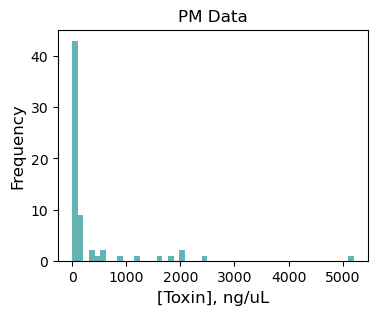

In [875]:
f, ax = plt.subplots(1,1, figsize=(4,3))
ax.hist(mdf3['toxin'], 
        bins=50, 
        color='#66b3b3')
ax.set_ylabel('Frequency', fontsize=12)
ax.set_xlabel('[Toxin], ng/uL', fontsize=12)
ax.set_title('PM Data');

#plt.savefig('../figures/biologHistogram.jpeg',bbox_inches='tight')

## Show overlap bw Biolog data and reconstructions

In [548]:
from matplotlib_venn import venn2

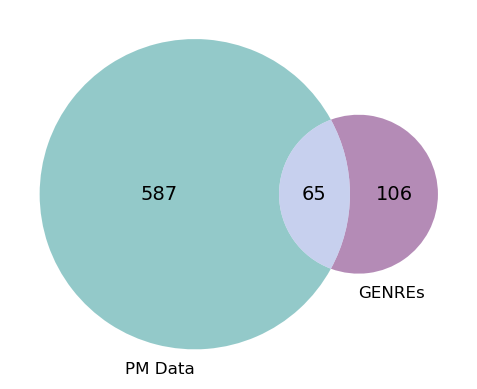

In [877]:
ax = venn2(subsets = (587,106, 65), # (Unique biolog metabolites, unique extracellular metabolites, overlap)
      set_labels = ('PM Data', 
                    'GENREs'),
      set_colors=("#66b3b3",
                  "#955a98"),alpha=0.7)

for text in ax.subset_labels:
    text.set_fontsize(14)

#plt.savefig('../figures/biologMetaboliteVenn.jpeg',bbox_inches='tight')

## Bin toxin levels (ng/mL) using definitions from Lei et al
- High: [420,) 
- Mid: [42, 420)
- Low: [0, 42)

In [498]:
mdf3['bins'] = pd.cut(mdf3['toxin'], bins=[0,42,420,5500], right=False, labels=['low','mid','high'])

In [543]:
mdf3['name'].nunique()

65

# Biolog flux simulations

In [322]:
# Minimal defined media, plus glucose
mdm_G = {'cpd00001_e',  # water
        'cpd00104_e', # Biotin
        'cpd00644_e', # Pantothenate
        'cpd00263_e', # Pyridoxine
        'cpd00149_e', # Cobalt
        'cpd00099_e', # Chloride
        'cpd10515_e', # Iron
        'cpd00030_e', # Manganese
        'cpd00254_e', # Magnesium
        'cpd00063_e', # Calcium
        'cpd00205_e', # Potassium
        'cpd00009_e', # Phosphate
        'cpd00971_e', # Sodium
        'cpd00242_e', # Carbonate
        'cpd00322_e', # L-Isoleucine
        'cpd00129_e', # L-Proline
        'cpd00156_e', # L-Valine
        'cpd00107_e', # L-Leucine
        'cpd00084_e', # L-Cysteine
        'cpd00065_e', # L-Tryptophan
        'cpd00027_e'} # Glucose

# minimal media exchange reactions
mdmg_ex = list('EX_' + x for x in mdm_G)

In [413]:
# Exchange reactions for biolog metabolites
mdf3['ex_id'] = 'EX_' + mdf3['ID'].astype(str)

In [414]:
blg = set(mdf3['ex_id'])

## R20291

In [419]:
temp = copy.deepcopy(r20291)

Read LP format model from file /var/folders/85/n42jk96d3hsbdfcjbr1qlmb80000gp/T/tmpzhkcho37.lp
Reading time = 0.01 seconds
: 1243 rows, 2626 columns, 11388 nonzeros


In [420]:
# Set lower bound of all ex-rxn = 0 unless in minimal media
for i in temp.exchanges:
    if not i.id in mdmg_ex:
        i.lower_bound = 0.
    else: 
        i.lower_bound = -1000.

In [421]:
# Get flux solutions for minimal media supplemented with biolog metabolites
fdf = pd.DataFrame()
mdf3['r20291_biomass']=''
for x in blg:
    try:
        temp.reactions.get_by_id(x).lower_bound = -1000
        temp.reactions.get_by_id(x).upper_bound = -1
        mdf3.loc[mdf3['ex_id']==x, 'r20291_biomass'] = temp.slim_optimize()
        flux = temp.optimize()
        fdf = pd.concat([fdf,flux.fluxes.rename(x)], axis=1)
        temp.reactions.get_by_id(x).upper_bound = 1000
        if x in blg.intersection(mdmg_ex):
            temp.reactions.get_by_id(x).lower_bound = -1000
        else:
            temp.reactions.get_by_id(x).lower_bound = 0
    except KeyError: 
        print(x, "is not in R20291 model")

/Users/dap5mb/opt/anaconda3/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/Users/dap5mb/opt/anaconda3/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/Users/dap5mb/opt/anaconda3/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/Users/dap5mb/opt/anaconda3/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


EX_cpd11584_e is not in R20291 model
EX_cpd01017_e is not in R20291 model
EX_cpd11591_e is not in R20291 model
EX_cpd11587_e is not in R20291 model


/Users/dap5mb/opt/anaconda3/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


EX_cpd11583_e is not in R20291 model


/Users/dap5mb/opt/anaconda3/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


EX_cpd11580_e is not in R20291 model


/Users/dap5mb/opt/anaconda3/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/Users/dap5mb/opt/anaconda3/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/Users/dap5mb/opt/anaconda3/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/Users/dap5mb/opt/anaconda3/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/Users/dap5mb/opt/anaconda3/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


In [435]:
fdf1 = fdf.T.reset_index()
fdf1.insert(0, 'model', 'r20291')

## CD630

In [437]:
temp1 = copy.deepcopy(cd630)

Read LP format model from file /var/folders/85/n42jk96d3hsbdfcjbr1qlmb80000gp/T/tmpknyu89tf.lp
Reading time = 0.01 seconds
: 1243 rows, 2646 columns, 11514 nonzeros


In [438]:
# Set lower bound of all ex-rxn = 0 unless in minimal media
for i in temp1.exchanges:
    if not i.id in mdmg_ex:
        i.lower_bound = 0.
    else: 
        i.lower_bound = -1000.

In [439]:
# Get flux solutions for minimal media supplemented with biolog metabolites
fdf = pd.DataFrame()
mdf3['cd630_biomass']=''
for x in blg:
    try:
        temp1.reactions.get_by_id(x).lower_bound = -1000
        temp1.reactions.get_by_id(x).upper_bound = -1
        mdf3.loc[mdf3['ex_id']==x, 'cd630_biomass'] = temp1.slim_optimize()
        flux = temp1.optimize()
        fdf = pd.concat([fdf,flux.fluxes.rename(x)], axis=1)
        temp1.reactions.get_by_id(x).upper_bound = 1000
        if x in blg.intersection(mdmg_ex):
            temp1.reactions.get_by_id(x).lower_bound = -1000
        else:
            temp1.reactions.get_by_id(x).lower_bound = 0
    except KeyError: 
        print(x, "is not in cd630 model")

/Users/dap5mb/opt/anaconda3/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/Users/dap5mb/opt/anaconda3/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/Users/dap5mb/opt/anaconda3/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


EX_cpd00100_e is not in cd630 model
EX_cpd00042_e is not in cd630 model
EX_cpd00155_e is not in cd630 model
EX_cpd00152_e is not in cd630 model


/Users/dap5mb/opt/anaconda3/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/Users/dap5mb/opt/anaconda3/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/Users/dap5mb/opt/anaconda3/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/Users/dap5mb/opt/anaconda3/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


EX_cpd00098_e is not in cd630 model


In [442]:
fdf = fdf.T.reset_index()
fdf.insert(0, 'model', 'cd630')

In [448]:
fdf2 = pd.concat([fdf,fdf1]).rename(columns={'index':'ex_id'})

# Process flux data and visualize

In [812]:
# Column map (binary toxin labels)
colDict2={
    'low':'#c1fefe',
    'mid':'#00b3b3',
    'high':'#006a6a'
        }
colNwk2 = mdf3.set_index(mdf3['ex_id'])['bins'].rename('Toxin')
colMap2 = pd.Series(colNwk2).map(colDict2)

In [836]:
# Process flux data for cd630
fdf_n = fdf.set_index('ex_id').reindex(colNwk2.sort_values().index).fillna(0).drop(columns='model') # Re-sort by toxin level and fill nans w/zero
fdf_n = fdf_n.loc[:, (fdf_n != 0).any(axis=0)] # remove rxns w/all zeroes
fdf_n = (fdf_n-fdf_n.min())/(fdf_n.max()-fdf_n.min()) # Min-Max normalization

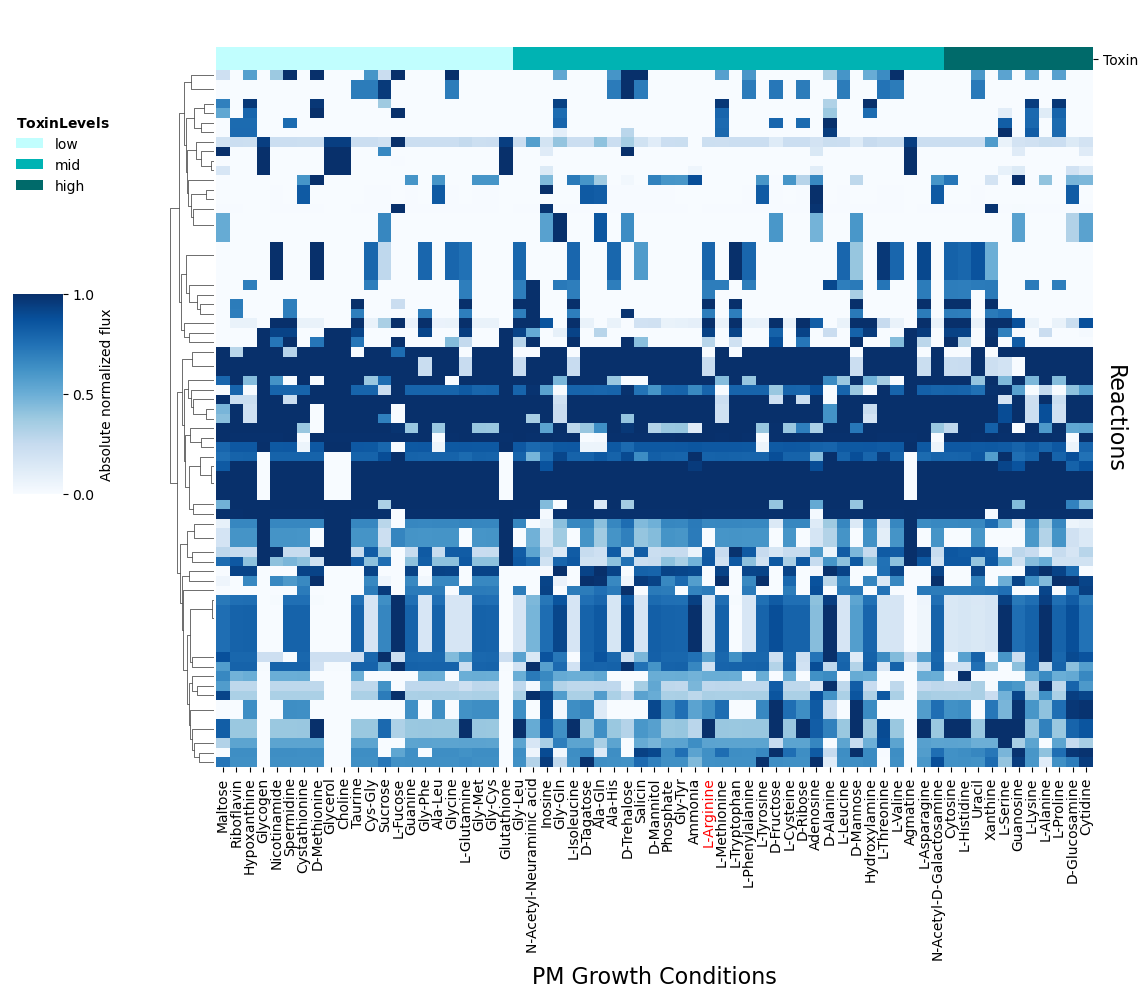

In [878]:
# Data for figure:
foo = np.abs(fdf_n.loc[: ,(fdf_n.var()>0.05)].T) # Filter out rxns w/flux variance < 0.05
# xtick labels: get biolog metabolite names, sort by toxin level for 
xlab = mdf3.loc[mdf3['ex_id'].isin(foo.columns), ['ex_id','name']].set_index('ex_id').reindex(colNwk2.sort_values().index)['name'].to_list()

##### Figure:
ax = sns.clustermap(foo, 
               cmap='Blues',
               col_colors=colMap2,
               col_cluster=False,
               dendrogram_ratio=0.05,
               yticklabels=False,
               xticklabels = xlab,
               cbar_pos=(-0.14, 0.5, 0.05, 0.2), # (left, bottom,width, height)
               cbar_kws={'label':'Absolute normalized flux', "ticks":[0,0.5,1]}
           )
ax.ax_heatmap.set_xlabel('PM Growth Conditions', fontsize = 16);
ax.ax_heatmap.set_ylabel('Reactions', fontsize = 16, rotation=270, va='bottom');

# Toxin Legend
for label in colDict2:
    ax.ax_col_dendrogram.bar(0,0, color = colDict2[label], label = label, linewidth=0)
ax.ax_col_dendrogram.legend(loc = [-0.235,-4], title='$\\bf{Toxin Levels}$',frameon=False)._legend_box.align = "left"

# Highlight arginine growth condition
ax.ax_heatmap.get_xticklabels()[36].set_color('red') 


#plt.savefig('../figures/biologCD630Flux.jpeg',bbox_inches='tight')

# Calculate Pearson's correlation bw rxns and PM toxin data

In [731]:
#p = [fdf_n.iloc[:,x].corr(t) for x in range(len(fdf_n.columns))]
p = [fdf_n.loc[: ,(fdf_n.var()>0.025)].iloc[:,x].corr(t) for x in range(109)]

In [732]:
pdf = pd.concat([pd.Series(fdf_n.columns).rename('rxn'), pd.Series(p).rename('pcorr')], axis=1)

In [733]:
pdf.sort_values(by='pcorr', ascending=False)
# No correlations w/toxin level

,rxn,pcorr
15,rxn00678_c,0.257776
24,rxn08669_c,0.210515
61,rxn05234_c,0.206897
33,rxn03482_c,0.185290
31,rxn05569_c,0.177201
...,...,...
612,rxn19080_c,NaN
613,rxn00493_c,NaN
614,rxn01270_c,NaN
615,rxn00527_c,NaN
